# Actor - Critic methods

In [1]:
# Google Colab:
#!pip3 install box2d-py
#!pip3 install gym[Box_2D]

In [7]:
import math
import copy
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class CriticMemory:
    def __init__(self, capacity, nS):
        self.capacity = capacity  # memory capacity (number of examples)
        self.count    = 0         # number of examples added
        self.S0 = torch.empty( (capacity, nS), dtype=torch.float32)
        self.S1 = torch.empty( (capacity, nS), dtype=torch.float32)        
        self.A0 = torch.empty( (capacity, 1),  dtype=torch.float32)
        self.R1 = torch.empty( (capacity, 1),  dtype=torch.float32)
        self.Dn = torch.empty( (capacity, 1),  dtype=torch.float32)

    def add(self, s0, a0, s1, r1, done):
        """ Add to memory (s0,a0,s1,r1, done) """
        idx = self.count % self.capacity
        self.S0[idx] = torch.tensor(s0, dtype=torch.float32)
        self.S1[idx] = torch.tensor(s1, dtype=torch.float32)
        self.A0[idx] = a0; self.R1[idx] = r1;  self.Dn[idx] = done
        self.count += 1

    def get(self, count):
        """ Return count of examples for (s0,s1,r1, dn) """        
        high = min(self.count, self.capacity)
        num  = min(count, high)
        ids = torch.randint(high = high, size = (num,) )
        return self.S0[ids], self.S1[ids], self.R1[ids], self.Dn[ids]

#========================================================================================    

class ActorMemory:
    def __init__(self, capacity, nS):
        self.capacity = capacity  # memory capacity (number of examples)
        self.count    = 0         # number of examples added
        self.S0 = torch.empty( (capacity, nS), dtype=torch.float32)        
        self.S1 = torch.empty( (capacity, nS), dtype=torch.float32)                
        self.A0 = torch.empty( (capacity, 1),  dtype=torch.int64)    
        self.R1 = torch.empty( (capacity, 1),  dtype=torch.float32)
        
    def add(self, s0, a0, s1, r1):
        """ Add to memory (s0,a0) """
        idx = self.count % self.capacity
        self.S0[idx] = torch.tensor(s0, dtype=torch.float32)
        self.S1[idx] = torch.tensor(s1, dtype=torch.float32)
        self.A0[idx] = a0;  self.R1[idx] = r1;
        self.count += 1

    def get(self, count):
        """ Return count of examples for (s0,a0) """        
        high = min(self.count, self.capacity)
        num  = min(count, high)
        ids = torch.randint(high = high, size = (num,) )
        return self.S0[ids], self.A0[ids], self.S1[ids], self.R1[ids]
        
#========================================================================================

class ActorModel(nn.Module):
    """ Neural network for pi(a|s) """
    def __init__(self, nS, nA, hiddens):
        super(ActorModel, self).__init__()
        
        neurons, layers = [nS] + hiddens + [nA], []        
        for i in range(len(neurons)-1):
            layers.append(nn.Linear(neurons[i], neurons[i+1]) )
            if i < len(neurons)-2:
                layers.append( nn.ReLU() )
        
        self.model = nn.Sequential(*layers)
 
    def forward(self, x):
        return self.model(x)        

#========================================================================================    

class CriticModel(nn.Module):
    """ Neural network for V(s) """
    def __init__(self, nS, nA, hiddens):
        super(CriticModel, self).__init__()
        
        neurons, layers = [nS] + hiddens + [1], []        
        for i in range(len(neurons)-1):
            layers.append(nn.Linear(neurons[i], neurons[i+1]) )
            if i < len(neurons)-2:
                layers.append( nn.ReLU() )
        
        self.model = nn.Sequential(*layers)
 
    def forward(self, x):
        return self.model(x)        

#========================================================================================    

class ActorCritic:
    """ A2C метод для дискретных действий """
    def __init__(self, env):
        self.env  = env                         # environment we work with
        self.low  = env.observation_space.low   # minimum observation values
        self.high = env.observation_space.high  # maximum observation values
        self.nA   =  self.env.action_space.n    # number of discrete actions
        self.nS   =  self.env.observation_space.shape[0] # number of state components

        self.params = {                      # default parameters
            'env'         : "Environment",
            'ticks'       : 200,                  
            'timeout'     : True,            # whether to consider reaching ticks as a terminal state
            'method'      : "a2c",           # kind of the method (a2c)     
            'gamma'       : 0.99,            # discount factor
            'eps1'        : 1.0,             # initial value epsilon
            'eps2'        : 0.001,           # final value   epsilon
            'decays'      : 1000,            # number of episodes to decay eps1 - > eps2
            'update'      : 10,              # target model update rate (in frames = time steps)         
            'batch_act'   : 100,             # batch size for training
            'batch_cri'   : 100,             # batch size for training
            'cap_act'     : 10000,           # memory size of actor
            'cap_cri'     : 10000,           # memory size 0f critic
            'rewrite'     : 1.0,             # rewrite memory (if < 1 - sorted)
            'actor'       : [256,128],       # hidden layers of actor
            'critic'      : [256,128],       # hidden layers of critic
            'scale'       : True,            # scale or not observe to [-1...1]
            'loss'        : 'huber',         # loss function (mse, huber)
            'optimizer'   : 'sgd',           # optimizer (sgd, adam)
            'lm_act'      : 0.001,           # learning rate for actor model
            'lm_cri'      : 0.001,           # learning rate for critic model
        }
        self.last_loss_act = 0.              # last loss of actor model
        self.last_loss_cri = 0.              # last loss of critic model
        self.history   = []

        print("low :   ", self.low)
        print("high:   ", self.high)        
        
    #------------------------------------------------------------------------------------

    def init(self):
        """ Create a neural network and optimizer """

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("device:", self.device)

        self.actor  = ActorModel (self.nS, self.nA, self.params['actor']).to(self.device)   # actor
        self.critic = CriticModel(self.nS, self.nA, self.params['critic']).to(self.device)  # critic
        self.target = CriticModel(self.nS, self.nA, self.params['critic']).to(self.device)  # target  critic

        self.best_model  = ActorModel(self.nS, self.nA, self.params['actor'])                 # best actor
        self.best_reward = -100000                                                            # best reward

        if   self.params['loss'] == 'mse':
             self.loss  = nn.MSELoss()
        elif self.params['loss'] == 'huber':
             self.loss = nn.HuberLoss()
        else:
            print("ERROR: Unknown loss function!!!")
        
        if   self.params['optimizer'] == 'sgd':
            self.optim_act = torch.optim.SGD(self.actor.parameters(),   lr=self.params['lm_act'], momentum=0.8)
            self.optim_cri = torch.optim.SGD(self.critic.parameters(),  lr=self.params['lm_cri'], momentum=0.8)
        elif self.params['optimizer'] == 'adam':
            self.optim_act = torch.optim.Adam(self.actor.parameters(),  lr=self.params['lm_act'])
            self.optim_cri = torch.optim.Adam(self.critic.parameters(), lr=self.params['lm_cri'])
        else:
            print("ERROR: Unknown optimizer!!!")

        self.actor_memo  = ActorMemory (self.params['cap_act'], self.nS)        
        self.critic_memo = CriticMemory(self.params['cap_cri'], self.nS)        
        
        self.V1 = None
        
        self.epsilon     = self.params['eps1']        # start value in epsilon greedy strategy
        self.decay_rate  = math.exp(math.log(self.params['eps2']/self.params['eps1'])/self.params['decays'])

        print(f"decay_rate: {self.decay_rate:.4f}")
        #print(self.actor)        
        #print(self.critic)        
       
    #------------------------------------------------------------------------------------

    def scale(self, obs):
        """ to [-1...1] """
        if self.params['scale']:
            return -1. + 2.*(obs - self.low)/(self.high-self.low)
        else:
            return obs
        
    #------------------------------------------------------------------------------------

    def policy(self, state):
        """ Return action according to epsilon greedy strategy """
        if np.random.random() < self.epsilon:            
            return np.random.randint(self.nA)    # random action

        x = torch.tensor(state, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            y = self.actor(x).detach().to('cpu').numpy() 
        return np.argmax(y)                      # best action

    #------------------------------------------------------------------------------------

    def run_episode(self, ticks = 200):
        """ Run one episode, keeping the environment model in memory """
        rew = 0                                  # total reward
        s0 = self.env.reset()                    # initial state
        s0 = self.scale (s0)                     # scale it
        a0 = self.policy(s0)                     # get action
        for t in range(1, ticks+1):
            s1, r1, done, _ = self.env.step(a0)
            s1 = self.scale (s1)
            a1 = self.policy(s1)

            dn = done and (self.params['timeout'] or t < ticks)                        
            self.critic_memo.add(s0, a0, s1, r1, float(dn) )
            self.actor_memo. add(s0, a0, s1, r1 )

            if self.frame % self.params['update'] == 0:  # copy model to target
                self.target.load_state_dict( self.critic.state_dict() ) 

            if self.critic_memo.count >= self.params['batch_cri']:    
                self.learn_critic()                         
                
                if self.actor_memo.count >= self.params['batch_act'] :    
                    self.learn_actor()                         
                
            rew += r1
            self.frame += 1

            if done:
                break

            s0, a0 = s1, a1
        return rew, t

    #------------------------------------------------------------------------------------

    def learn(self, episodes = 100000, stat1 = 10, stat2 = 100, plots = 1000, rews_range=[-200, -80]):
        """ Repeat episodes episodes times """
        self.frame = 1        
        rews, lens, mean, beg   = [], [], 0, time.process_time()
        for episode in range(1, episodes+1):
            rew, t = self.run_episode( self.params['ticks'] )
            rews.append( rew )
            lens.append(t)
            
            self.epsilon *= self.decay_rate                # epsilon-decay
            if self.epsilon < self.params['eps2']:
                self.epsilon = 0.
                
            if episode % stat1 == 0:
                self.history.append([episode, np.mean(rews[-stat1:]), np.mean(rews[-stat2:])])                                      
                
            if  episode % stat2 == 0:                               
                mean, std    = np.mean(rews[-stat2:]), np.std(rews[-stat2:])    
                lensM, lensS = np.mean(lens[-stat2:]), np.std(lens[-stat2:])                    
                if mean > self.best_reward:
                    self.best_reward = mean
                    self.best_model.load_state_dict( self.actor.state_dict() )                     
                V = self.V1.to('cpu') if self.V1 != None else []
                print(f"{episode:6d} rew:{mean:7.1f} ± {std/stat2**0.5:3.1f}, best:{self.best_reward:7.2f}, ticks:{lensM:3.0f}, eps:{self.epsilon:.3f}, V:{V.mean():6.2f} ±{V.std():6.2f}, losses (cri:{self.last_loss_cri:7.3f}, act:{self.last_loss_act:7.3f}), {(time.process_time() - beg):3.0f}s")
                beg = time.process_time()
                
            if  episode % plots == 0:                   
                self.plot(f"{self.params['env']}  Episode: {episode}  best: {self.best_reward:7.1f}", rews_range)
            
    #------------------------------------------------------------------------------------

    def learn_critic(self):
        """ Critic model training """                
        S0, S1, R1, D1 = self.critic_memo.get(self.params['batch_cri'])
        S0 = S0.to(self.device);  S1 = S1.to(self.device); 
        R1 = R1.to(self.device);  D1 = D1.to(self.device)                
        
        V0 = self.critic(S0)
        with torch.no_grad():
            V1 = self.target(S1)   
                
        L = self.loss(R1 + self.params['gamma']*V1*(1.-D1),  V0)
        
        self.optim_cri.zero_grad()       # reset the gradients
        L.backward()                     # calculate gradients
        self.optim_cri.step()            # adjusting parameters        

        self.last_loss_cri = L.detach().item()
        self.V1 = V1.detach().cpu()

    #------------------------------------------------------------------------------------

    def learn_actor(self):
        S0, A0, S1, R1  = self.actor_memo.get(self.params['batch_act'])
        S0 = S0.to(self.device);  A0 = A0.to(self.device); 
        S1 = S1.to(self.device);  R1 = R1.to(self.device); 
        
        with torch.no_grad():
            V0 = self.critic(S0)
            V1 = self.critic(S1)
            W  = R1 + self.params['gamma']*V1 - V0
        
        probs = torch.softmax( self.actor(S0), 1 )
        logprob = (probs+1.e-5).log()                        
        logprob = torch.gather(logprob, 1, A0.view(-1,1)).squeeze()            
                
        L = -(W * logprob).mean()         # calculate loss                    
        self.optim_act.zero_grad()        # reset the gradients
        L.backward()                      # calculate gradients                    
        self.optim_act.step()             # adjusting parameters             
                
        self.last_loss_act = L.item()        
        
    #------------------------------------------------------------------------------------
        
    def plot(self, text, rews_range):
        """ Plot histogram for states and actions """        
        hist_S, bins_S = np.histogram(self.critic_memo.S1, bins=np.linspace(0, math.sqrt(self.nS), 101),   density=True)        
        hist_A, bins_A = np.histogram(self.critic_memo.A0, bins=np.linspace(-0.5, self.nA-0.5, self.nA+1), density=True)

        fig, ax = plt.subplots(1, 3, figsize=(16,6), gridspec_kw={'width_ratios': [2, 1, 5]})        
        plt.suptitle(text, fontsize=18)
                                
        ax[0].set_xlim(min(bins_S), max(bins_S))    # histogram for S1
        ax[0].grid(axis='x', alpha=0.75); ax[0].grid(axis='y', alpha=0.75)
        ax[0].set_xlabel('|s1|', fontsize=16)
        bins = [ (bins_S[i]+bins_S[i+1])/2 for i in range(len(bins_S)-1)]
        ax[0].bar(bins, hist_S, width=0.5, color='blue')
                        
        ax[1].set_xlim(min(bins_A), max(bins_A))    # histogram for A
        ax[1].grid(axis='x', alpha=0.75); ax[1].grid(axis='y', alpha=0.75)
        ax[1].set_xlabel('actions', fontsize=16)
        ax[1].set_xticks(np.arange(self.nA));
        bins = [ (bins_A[i]+bins_A[i+1])/2 for i in range(len(bins_A)-1)]        
        ax[1].bar(bins, hist_A, width=0.5, color='blue')

        history = np.array(self.history)            # loss history
        ax[2].plot(history[:,0], history[:,1], linewidth=1)
        ax[2].plot(history[:,0], history[:,2], linewidth=2)
        ax[2].set_ylim(rews_range[0], rews_range[1]);
        ax[2].set_xlabel('episode', fontsize=16)        
        ax[2].grid(axis='x', alpha=0.75); ax[2].grid(axis='y', alpha=0.75)
        params = [ f"{k:9s}: {v}\n" for k,v in self.params.items()]
        ax[2].text(history[0,0], rews_range[0], "".join(params), {'fontsize':12, 'fontname':'monospace'})

        plt.show()
        
    #------------------------------------------------------------------------------------

    def test(self, episodes = 1000, ticks = 1000, render = False):
        """ Q-Function Testing """
        rews = []
        for episode in range(1, episodes+1):
            tot = 0
            obs =  self.env.reset()
            for _ in range(ticks):
                action = self.policy( self.scale(obs) )
                obs, rew, done, _ = self.env.step(action)
                tot += rew
                if render:
                    env.render()
                if done:
                    break
            rews.append(tot)
            if episode % 100:
                print(f"\r {episode:4d}: Reward: {np.mean(rews):7.3f} ± {np.std(rews)/len(rews)**0.5:.3f}", end="")
        print()
        

## CartPole

low :    [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
high:    [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
device: cuda:0
decay_rate: 0.9931
{'env': 'CartPole-v0', 'ticks': 200, 'timeout': True, 'method': 'a2c', 'gamma': 0.99, 'eps1': 1.0, 'eps2': 0.001, 'decays': 1000, 'update': 10, 'batch_act': 100, 'batch_cri': 100, 'cap_act': 1000, 'cap_cri': 10000, 'rewrite': 1.0, 'actor': [64, 32], 'critic': [128, 64], 'scale': False, 'loss': 'mse', 'optimizer': 'adam', 'lm_act': 0.001, 'lm_cri': 0.001}
   100 rew:   43.3 ± 3.2, best:  43.34, ticks: 43, eps:0.501, Q:   22.89 ± 10.27, loss_cri:  8.506,  loss_act:  0.186,  18s
   200 rew:   84.1 ± 3.4, best:  84.07, ticks: 84, eps:0.251, Q:   36.00 ± 17.00, loss_cri:  5.098,  loss_act:  0.040,  37s
   300 rew:  140.0 ± 4.8, best: 139.98, ticks:140, eps:0.126, Q:   48.39 ± 20.78, loss_cri:  0.833,  loss_act:  0.061,  60s
   400 rew:  173.5 ± 4.4, best: 173.47, ticks:173, eps:0.063, Q:   59.33 ± 15.54, loss_cri:  2.304,

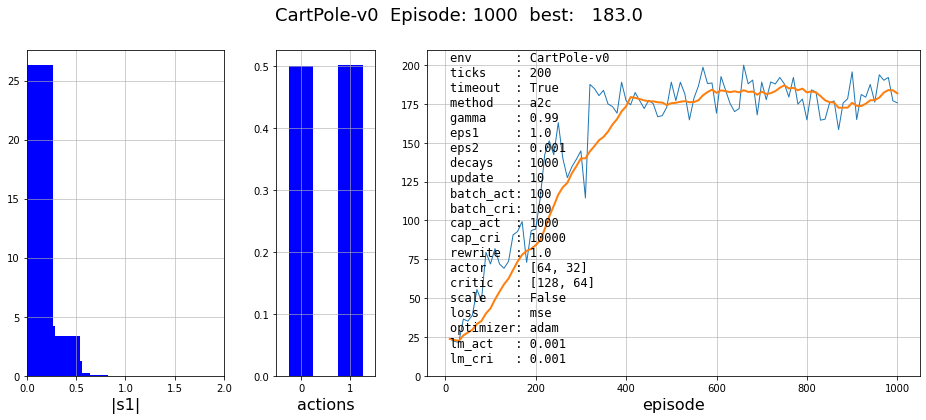

KeyboardInterrupt: 

In [8]:
env_name = "CartPole-v0"    # (nS=4, nA=2)
env = gym.make(env_name)

ac = ActorCritic( env )

ac.params = {                   # default parameters
            'env'         : env_name,
            'ticks'       : 200,                  
            'timeout'     : False,            # whether to consider reaching ticks as a terminal state
            'method'      : "a2c",           # kind of the method (a2c)     
            'gamma'       : 0.99,            # discount factor
            'eps1'        : 1.0,             # initial value epsilon
            'eps2'        : 0.001,           # final value   epsilon
            'decays'      : 1000,            # number of episodes to decay eps1 - > eps2
            'update'      : 10,              # target model update rate (in frames = time steps)         
            'batch_act'   : 100,             # batch size for training
            'batch_cri'   : 100,             # batch size for training
            'cap_act'     : 1000,            # memory size of actor
            'cap_cri'     : 10000,           # memory size 0f critic            
            'actor'       : [64,32],         # hidden layers of actor
            'critic'      : [128,64],        # hidden layers of critic
            'scale'       : False,           # scale or not observe to [-1...1]
            'loss'        : 'mse',           # loss function (mse, huber)
            'optimizer'   : 'adam',          # optimizer (sgd, adam)
            'lm_act'      : 0.001,           # learning rate for actor model
            'lm_cri'      : 0.001,           # learning rate for critic model
}

ac.init()
print(ac.params)
ac.learn(episodes = 3000,  rews_range=[0, 210] )

## MountainCar-v0

low :    [-1.2  -0.07]
high:    [0.6  0.07]
device: cuda:0
decay_rate: 0.9931
{'env': 'MountainCar-v0', 'ticks': 200, 'timeout': True, 'method': 'a2c', 'gamma': 0.99, 'eps1': 1.0, 'eps2': 0.001, 'decays': 1000, 'update': 100, 'batch_act': 100, 'batch_cri': 100, 'cap_act': 1000, 'cap_cri': 10000, 'rewrite': 1.0, 'actor': [128, 64], 'critic': [128, 64], 'scale': True, 'loss': 'mse', 'optimizer': 'adam', 'lm_act': 0.001, 'lm_cri': 0.001}
   100 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.501, Q:  -65.70 ±  2.72, loss_cri:  0.188,  loss_act: -1.334,  87s
   200 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.251, Q:  -66.88 ±  5.64, loss_cri:  0.699,  loss_act: -0.605, 126s
   300 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.126, Q:  -65.40 ±  3.86, loss_cri:  0.444,  loss_act: -0.126, 136s
   400 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.063, Q:  -64.64 ±  5.11, loss_cri:  0.354,  loss_act: -0.145, 100s
   500 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.032, Q: 

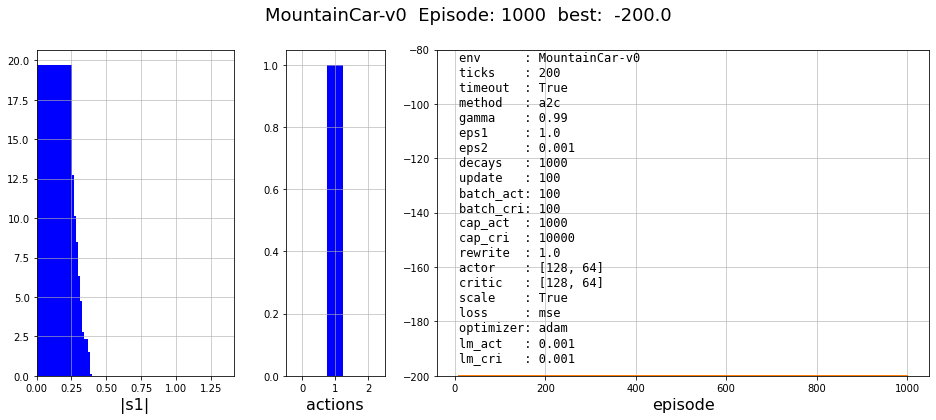

KeyboardInterrupt: 

In [9]:
env_name = "MountainCar-v0"  # (nS=2, nA=3)
env = gym.make(env_name)

ac = ActorCritic( env )

ac.params = {                   # default parameters
            'env'         : env_name,
            'ticks'       : 200,                  
            'timeout'     : True,            # whether to consider reaching ticks as a terminal state
            'method'      : "a2c",           # kind of the method (a2c)     
            'gamma'       : 0.99,            # discount factor
            'eps1'        : 1.0,             # initial value epsilon
            'eps2'        : 0.001,           # final value   epsilon
            'decays'      : 1000,            # number of episodes to decay eps1 - > eps2
            'update'      : 100,             # target model update rate (in frames = time steps)         
            'batch_act'   : 100,             # batch size for training
            'batch_cri'   : 100,             # batch size for training
            'cap_act'     : 1000,            # memory size of actor
            'cap_cri'     : 10000,           # memory size 0f critic            
            'actor'       : [128,64],        # hidden layers of actor
            'critic'      : [128,64],        # hidden layers of critic
            'scale'       : True,            # scale or not observe to [-1...1]
            'loss'        : 'mse',           # loss function (mse, huber)
            'optimizer'   : 'adam',          # optimizer (sgd, adam)
            'lm_act'      : 0.001,           # learning rate for actor model
            'lm_cri'      : 0.001,           # learning rate for critic model
}

ac.init()
print(ac.params)
ac.learn(episodes = 3000,  rews_range=[-200, -80])

## LunarLander-v2

In [ ]:
env_name = "LunarLander-v2" # (nS=8, nA=4)
env = gym.make(env_name)

dqn = DQN( env )

dqn.params = {
    'env'      : env_name,
    'ticks'    : 500,
    'timeout'  : True,      # whether to consider reaching ticks as a terminal state
    'method'   : "DQN",     # kind of the method (DQN, DDQN)     
    'gamma'    : 0.99,      # discount factor
    'eps1'     : 1.0,       # initial value epsilon
    'eps2'     : 0.001,     # final value   epsilon
    'decays'   : 1000,      # number of episodes to decay eps1 - > eps2
    'update'   : 1000,      # target model update rate (in frames = time steps)             
    'batch'    : 100,       # batch size for training
    'capacity' : 100000,    # memory size
    'rewrite'  : 1,         # rewrite memory (if < 1 - sorted)
    'hiddens'  : [256,64],  # hidden layers
    'scale'    : False,     # scale or not observe to [-1...1]
    'loss'     : 'huber',   # loss function (mse, huber)
    'optimizer': 'adam',    # optimizer (sgd, adam)    
    'lm'       : 0.0001,     # learning rate           
}

dqn.init()
print(dqn.params)
dqn.learn(episodes = 3000, rews_range=[-100, 300])

## Test best model

In [ ]:
dqn.model.load_state_dict( dqn.best_model.state_dict() )
dqn.test(episodes = 1, ticks=500, render=True)
env.close()

## Save model

In [ ]:
import datetime
  
state = {'info':      f"{env_name}: Q-function, Reward:  286",     
         'date':      datetime.datetime.now(),  
         'model':     str(dqn.best_model),
         'state' :    dqn.best_model.state_dict(),  
        } 
print(dqn.params['hiddens'])
torch.save(state, f"{env_name}_{'_'.join([str(x) for x in dqn.params['hiddens']])}.286.pt")
print(state['model'])

## Plot policy

In [ ]:
from   matplotlib import colors

bins = (101, 101)   
low  = dqn.low    # minimum observation values
high = dqn.high   # maximum observation values
step = (high-low)/bins

def table(model, bins = (101, 101)):    
    """ Get 2D table of policy function """
    res = np.empty(bins)
    step = (high-low)/bins
    indx = torch.cartesian_prod(torch.arange(0, bins[0]), torch.arange(0, bins[1]))
    gpu  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    X = torch.tensor(low, dtype = torch.float32) + indx*torch.tensor(step, dtype = torch.float32)        
    X = -1. + 2.*(X - low)/(high-low)
    
    with torch.no_grad():
        X = X.to(gpu)
        Y = model.to(gpu)(X).cpu()     
        print(Y.shape)
        Y = torch.argmax(Y, 1).float()
        print(Y.shape)
    
    return Y.view(bins[0], bins[1]).numpy()

def plot(mat, title, d_ticks=1000, bins = (101,101)):
    """ Plot table """
    def index(state):        
        indx = ((state - low)/step).astype(int)
        indx = np.clip(indx, (0,0), (bins[0]-1, bins[1]-1))
        return tuple( indx )

    g, m, x0   = index([0.5, 0.]), index([-math.pi/6, 0.]), np.array([ index([-0.6, 0.]), index([-0.4, 0.]) ])
    cmap = colors.ListedColormap(['blue', 'white', 'red'])    
    
    plt.imshow(mat.T, interpolation='none', origin='lower', cmap= cmap, alpha=0.5)

    plt.title (title, {'fontsize': 16})
    plt.xlabel('x', {'fontsize': 16});         plt.ylabel('v', {'fontsize': 16}) 
    plt.axhline(g[1], c="black", linewidth=1); plt.axvline(g[0], c="black", linewidth=1)
    plt.axvline(m[0], c="black", linewidth=1)
    plt.axvline(x0[0][0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    plt.axvline(x0[1][0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    ticks = range(0, bins[0], d_ticks)
    plt.xticks( ticks, np.round(100*np.linspace(low[0], high[0], len(ticks)))/100 )
    plt.yticks( ticks, np.round(100*np.linspace(low[1], high[1], len(ticks)))/100 )

     
plt.figure(figsize=(10,10))
res = table(dqn.best_model, bins = bins)
print(res.shape, res.min(), res.max(), res.mean())
plot(res, 'Policy function, Reward: -98.1 ± 0.1 in [-107, -83]', d_ticks=100, bins = bins)
plt.show()

In [ ]:
import numpy as np
ar = np.array([[1,1],[2,0], [3,2]])
ar[ ar[:, -1].argsort() ] [::-1]

In [ ]:
ar = [ [ np.array([1,2]), np.array([3,4])], [ np.array([1,2]), np.array([3,4])] ]
np.array(ar)

In [ ]:
list(2)